In [626]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# @Author: Mingyeong Yang (mmingyeong@kasi.re.kr)
# @Date: 2024-01-22
# @Filename: plt_lc.ipynb
# scp -r -p 7774 mmingyeong@seondeok.kasi.re.kr:~/sphr4 C:\Users\mming

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import pandas as pd

# Introduction

이 코드는 Horizon Run 4의 Light Cone Data를 plot하기 위한 코드입니다.\
Kim, Juhan, et al. "Horizon Run 4 simulation: Coupled evolution of galaxies and large-scale structures of the Universe." arXiv preprint arXiv:1508.05107 (2015).

위 시뮬레이션에서 제공하는 여러 형식의 데이터 중에서 All-sky past lightcone data (out to z=1.5)를 plot합니다.
LC data는 아래와 같은 정보들을 제공합니다.
* Galaxy ID (8 bytes)
* X/Y/Z position in real space [cMpc/h] (8 bytes per each)
* X/Y/Z peculiar velocity [km/s] (4 bytes per each)
* Mass proxy (similar to subhalo mass) [Msun/h] (4 bytes)

우리는 X/Y/Z position 데이터를 사용하여 2차원 평면에 Galaxy 분포를 plot할 것입니다.

## Plot Algorithm
1. x,y,z dataset 준비
2. x,y,z dataset distribution histogram 확인
3. r, phi, theta dataset # 직교 좌표 데이터를 구면 좌표 데이터로 변환.
4. r, phi, theta dataset distribution histogram 확인 # 구면 좌표계의 phi
5. RA, DEC 범위 설정 # 위 histogram을 참고하여
6. plot할 r, phi dataset 추출.
7. plot dataset으로 극좌표계에 plot # 이때 r=z, phi=RA에 상응. # 극 좌표계의 phi

### USER Giude
snapshot -> 원하는 snapshot를 put\
dec -> projection 원하는 Declination (deg) put\
theta_mark_min = theta_mark - 10 # declination 범위 조정\
theta_mark_max = theta_mark + 10 # declination 범위 조정\
위는 delclination 기준 +10, -10 deg 범위이다.

In [627]:
Snapshot = 75
file_path = f"./LC.00{Snapshot}.hdf5"
basename = os.path.basename(file_path)

In [628]:
def read_hdf5(file_path:str):
    """read the hdf5 file"""
    data = {}
    with h5py.File(file_path, 'r') as f:
        data["ID"] = f["ID"][:]
        data["mass"] = f["mass"][:]
        data["vx"] = f["vx"][:]
        data["vy"] = f["vy"][:]
        data["vz"] = f["vz"][:]
        data["x"] = f["x"][:]
        data["y"] = f["y"][:]
        data["z"] = f["z"][:]

    return data

## 1. x,y,z dataset 준비

In [629]:
# 1. x,y,z dataset 준비
data = read_hdf5(file_path)
x_dataset = data["x"]
y_dataset = data["y"]
z_dataset = data["z"]

## 2. x,y,z dataset distribution histogram 확인

<Figure size 640x480 with 0 Axes>

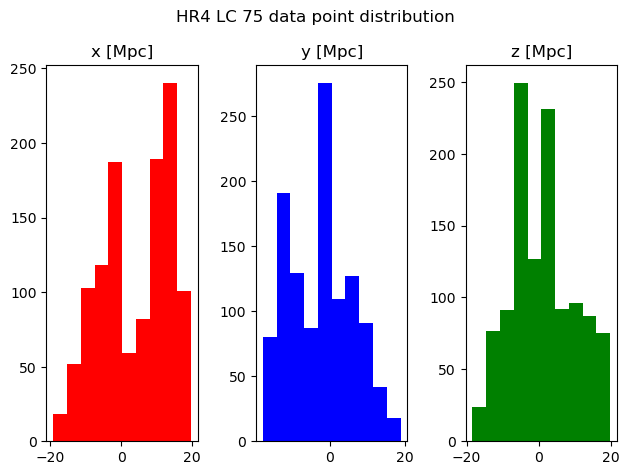

In [630]:
# 2. x,y,z dataset distribution histogram 확인

plt.figure()

fig, ax = plt.subplots(1, 3)

ax[0].hist(x_dataset, bins=10, color="r")
ax[0].set_title("x [Mpc]")

ax[1].hist(y_dataset, bins=10, color="b")
ax[1].set_title("y [Mpc]")

ax[2].hist(z_dataset, bins=10, color="g")
ax[2].set_title("z [Mpc]")

plt.suptitle(f"HR4 LC {Snapshot} data point distribution")
fig.tight_layout()
plt.show()

In [631]:
def cartesian_to_spherical_vec(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y, x) # radian
    phi = np.arccos(z / r) # radian
    theta_deg = np.rad2deg(theta)
    phi_deg = np.rad2deg(phi)
    
    return r, theta_deg, phi_deg

## 3. r, phi, theta dataset # 직교 좌표 데이터를 구면 좌표 데이터로 변환.

In [632]:
# 3. r, phi, theta dataset # 직교 좌표 데이터를 구면 좌표 데이터로 변환.

r_dataset, theta_dataset, phi_dataset  = cartesian_to_spherical_vec(x_dataset, y_dataset, z_dataset)

In [633]:
theta_dataset

array([ 17.86730298, 168.19593482,  12.5452204 , ..., 149.10388096,
       128.71269539, 138.42625707])

## 4. r, phi, theta dataset distribution histogram 확인 # 구면 좌표계의 phi

<Figure size 640x480 with 0 Axes>

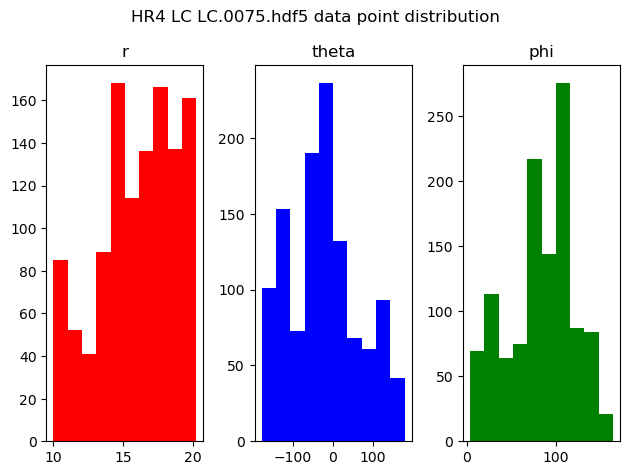

In [634]:
# 4. r, phi, theta dataset distribution histogram 확인 # 구면 좌표계의 phi

plt.figure()

fig, ax = plt.subplots(1, 3)

ax[0].hist(r_dataset, bins=10, color="r")
ax[0].set_title("r")

ax[1].hist(theta_dataset, bins=10, color="b")
ax[1].set_title("theta")

ax[2].hist(phi_dataset, bins=10, color="g")
ax[2].set_title("phi")

plt.suptitle(f"HR4 LC {basename} data point distribution")
fig.tight_layout()
plt.show()

## 5. RA, DEC 범위 설정 

위 histogram을 참고하여 RA, DEC 범위를 결정하여야 한다.

Declination=90-θ, RA=φ-180

Ex. theta data 범위를 보고 Declination 범위를 결정할 수 있다.

Declination = 0 deg, RA = 12h ~ 18h (180 ~ 270 deg)의 범위를 plot하고 싶다면\
theta = 90 deg, phi = 0 ~ 90 deg로 제한하여 data를 plot한다.

In [635]:
## 5. RA, DEC 범위 설정 

dec = 0 # deg 보고자하는 declination을 입력.
ra_min_select = [0, 90, 180, 270] # deg == [0h, 6h, 12h, 18h]
ra_min = ra_min_select[2]

theta_mark = 90 - dec # deg
phi_min_mark = ra_min+180 # deg
if phi_min_mark >=360:
    phi_min_mark = phi_min_mark - 360
phi_max_mark = phi_min_mark + 90 #deg

## 6. plot할 r, phi dataset 추출.

6.1 theta_mark 값을 가지는 array index 추출\
theta_mark - 1 < val < theta_mark + 1

6.2 해당 index의 r, phi array 추출

6.3 phi_mark 범위에 해당하는 array index 추출\
phi_min_mark <  val < phi_max_mark

In [636]:
## 6. plot할 r, phi dataset 추출.

theta_mark_min = theta_mark - 20 # declination 범위 조정
theta_mark_max = theta_mark + 20 # declination 범위 조정

theta_index = np.where((theta_mark_min<theta_dataset)&(theta_dataset<theta_mark_max))
dec_fixed_r_data = r_dataset[theta_index]
dec_fixed_phi_data = phi_dataset[theta_index]

phi_index = np.where((phi_min_mark<dec_fixed_phi_data)&(dec_fixed_phi_data<phi_max_mark))
final_r_data = dec_fixed_r_data[phi_index]
final_phi_data = dec_fixed_phi_data[phi_index]
final_phi_data_rad = np.deg2rad(final_phi_data)

<Figure size 640x480 with 0 Axes>

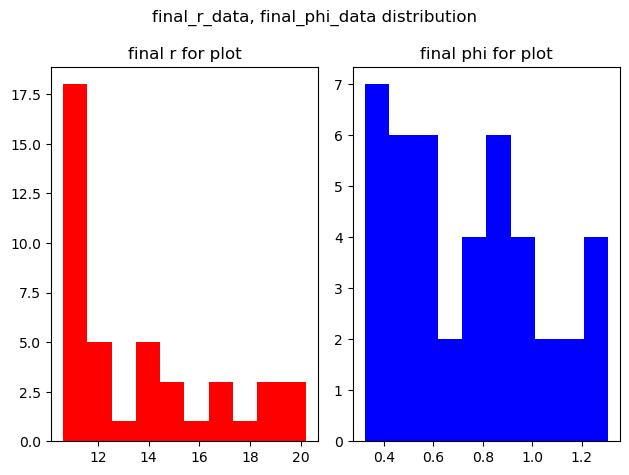

In [637]:
plt.figure()

fig, ax = plt.subplots(1, 2)

ax[0].hist(final_r_data, bins=10, color="r")
ax[0].set_title("final r for plot")

ax[1].hist(final_phi_data_rad, bins=10, color="b")
ax[1].set_title("final phi for plot")

plt.suptitle(f"final_r_data, final_phi_data distribution")
fig.tight_layout()
plt.show()

## 7. plot dataset으로 극좌표계에 plot # 이때 r=z, phi=RA에 상응. # 극 좌표계의 phi

현재 그래프
[ r ] = cMpc/h, [ RA ] = °

* z 단위와 hour 단위로 변경해야 한다.

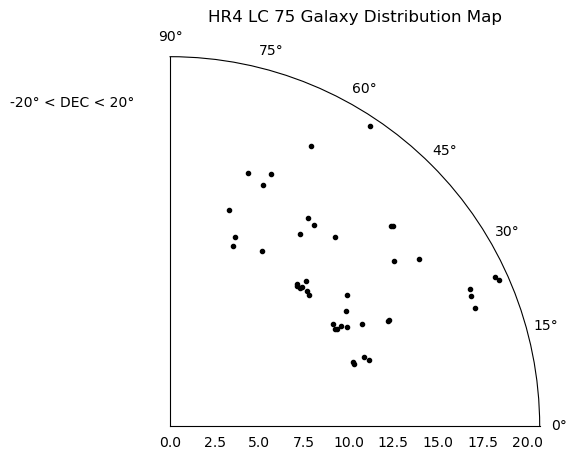

In [638]:
# 7. plot dataset으로 극좌표계에 plot # 이때 r=z, phi=RA에 상응. # 극 좌표계의 phi

# 극좌표계 그래프 생성
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# 극좌표계 그래프 그리기
ax.plot(final_phi_data_rad, final_r_data, 'k.')

ax.set_thetamin(phi_min_mark)
ax.set_thetamax(phi_max_mark)

ax.grid()

plt.title(f"HR4 LC {Snapshot} Galaxy Distribution Map")
plt.text(90, 20, f"{90-theta_mark_max}° < DEC < {90-theta_mark_min}°")
# 그래프 보이기
plt.show()